# Word2Vec SkipGram Model

In [4]:
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

# Sample text corpus
corpus = "The quick brown fox jumps over the lazy dog."
corpus = corpus.lower().replace('.', '')  # Preprocessing: to lower case and remove punctuation

# Tokenize and build vocabulary
tokens = corpus.split()
vocab = set(tokens)
vocab_size = len(vocab)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Generate target-context pairs with window size 1
target_context_pairs = []
for i, target in enumerate(tokens):
    context = [tokens[j] for j in range(max(0, i-1), min(len(tokens), i+2)) if j != i]
    for c in context:
        target_context_pairs.append((word_to_index[target], word_to_index[c]))

# Convert to tensors
targets, contexts = zip(*target_context_pairs)
target_tensor = torch.LongTensor(targets)
context_tensor = torch.LongTensor(contexts)

# Create DataLoader for training data
train_dataset = TensorDataset(target_tensor, context_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Display vocabulary and some sample pairs
vocab, target_context_pairs[:5]


({'brown', 'dog', 'fox', 'jumps', 'lazy', 'over', 'quick', 'the'},
 [(4, 3), (3, 4), (3, 7), (7, 3), (7, 2)])

In [6]:
# Re-initialize model with the new vocab size
skipgram_model = SkipGram(len(vocab), embed_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(skipgram_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (target_batch, context_batch) in enumerate(train_loader):
        # Forward pass
        scores = skipgram_model(target_batch, context_batch)
        
        # Compute loss
        loss = criterion(scores, context_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training completed.")
torch.save(skipgram_model.state_dict(), 'skipgram_model.pth')



Epoch [10/100], Loss: 3.3163
Epoch [20/100], Loss: 2.4085
Epoch [30/100], Loss: 1.8077
Epoch [40/100], Loss: 1.3994
Epoch [50/100], Loss: 1.1259
Epoch [60/100], Loss: 0.9555
Epoch [70/100], Loss: 0.8586
Epoch [80/100], Loss: 0.8150
Epoch [90/100], Loss: 0.7905
Epoch [100/100], Loss: 0.7754
Training completed.


In [10]:
# Load the saved model
model = SkipGram(len(vocab), embed_dim)
model.load_state_dict(torch.load('skipgram_model.pth'))
model.eval()

# Get the embeddings
def get_embedding(word):
    if word in word_to_index:
        word_idx = torch.tensor([word_to_index[word]], dtype=torch.long)
        return model.in_embed(word_idx).detach().numpy()
    else:
        return None  # or handle OOV differently

# Example usage
embedding_vector = get_embedding('quick')
print(f'quick is represented by {embedding_vector}')



quick is represented by [[-0.50501394 -0.17972921  1.3839511  -0.07640239 -0.07448568 -1.3944459
  -0.39962184  1.4717467   2.072118   -1.5519279 ]]


In [13]:
# Generate a list of 20 contextually related words
# For demonstration, we'll use words related to technology and nature
tech_words = ['computer', 'software', 'hardware', 'internet', 'database', 'algorithm']
nature_words = ['tree', 'forest', 'river', 'mountain', 'flower', 'animal']

# Combine the words
words_list = tech_words + nature_words

# For demonstration, let's assume these words are the new vocabulary
new_vocab = set(words_list)
new_word_to_index = {word: i for i, word in enumerate(new_vocab)}
new_index_to_word = {i: word for word, i in new_word_to_index.items()}

# Display the new vocabulary
new_vocab

# Add more words to reach 20
additional_tech_words = ['network', 'cloud', 'encryption', 'protocol']
additional_nature_words = ['ocean', 'beach', 'sky', 'sun']

# Combine the words
words_list = tech_words + additional_tech_words + nature_words + additional_nature_words

# Update the new vocabulary
new_vocab = set(words_list)
new_word_to_index = {word: i for i, word in enumerate(new_vocab)}
new_index_to_word = {i: word for word, i in new_word_to_index.items()}

# Display the new vocabulary
new_vocab


{'algorithm',
 'animal',
 'beach',
 'cloud',
 'computer',
 'database',
 'encryption',
 'flower',
 'forest',
 'hardware',
 'internet',
 'mountain',
 'network',
 'ocean',
 'protocol',
 'river',
 'sky',
 'software',
 'sun',
 'tree'}

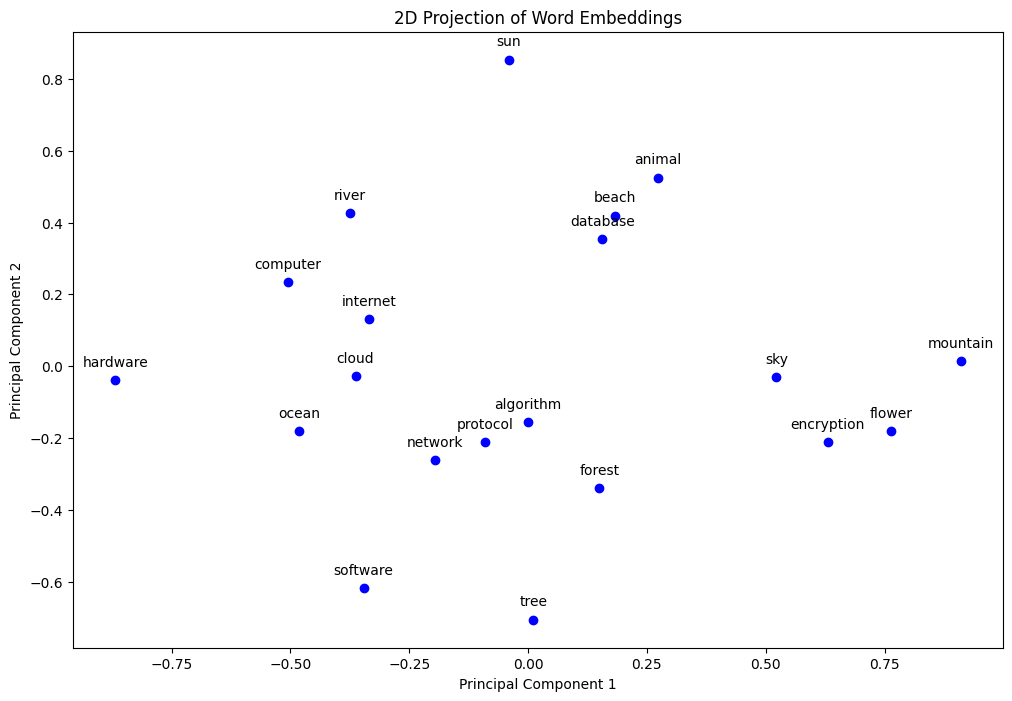

In [14]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generate synthetic 10-dimensional embeddings for the new words
# In a real-world scenario, these would be obtained by fine-tuning the model on new data
np.random.seed(0)  # for reproducibility
embeddings = np.random.rand(len(new_vocab), 10)

# Perform PCA to reduce the dimensions to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue')

# Annotate the points
for i, word in enumerate(new_vocab):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('2D Projection of Word Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# Complete Skip-gram model with random words as context - unrealistic but OK for demonstration
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Define the Skip-gram model
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_dim)
        self.out_embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, target, context):
        in_embeds = self.in_embed(target)
        out_embeds = self.out_embed(context)
        
        # Calculate dot product for each pair and reshape to (B, vocab_size)
        scores = torch.matmul(in_embeds, self.out_embed.weight.t())
        
        return scores

# Generate sample data (target, context)
def generate_sample_data(num_samples=1000, vocab_size=100):
    target_words = [random.randint(0, vocab_size-1) for _ in range(num_samples)]
    context_words = [random.randint(0, vocab_size-1) for _ in range(num_samples)]
    return target_words, context_words

# Initialize model and parameters
vocab_size = 100
embed_dim = 10
skipgram_model = SkipGram(vocab_size, embed_dim)

# Generate sample data
num_samples = 1000
target_words, context_words = generate_sample_data(num_samples, vocab_size)
target_tensor = torch.LongTensor(target_words)
context_tensor = torch.LongTensor(context_words)

# Training configurations
learning_rate = 0.01
num_epochs = 100
batch_size = 32

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(skipgram_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Shuffle data
    shuffle_indices = torch.randperm(num_samples)
    target_tensor = target_tensor[shuffle_indices]
    context_tensor = context_tensor[shuffle_indices]
    
    for i in range(0, num_samples, batch_size):
        # Prepare mini-batch
        target_batch = target_tensor[i:i+batch_size]
        context_batch = context_tensor[i:i+batch_size]
        
        # Forward pass
        scores = skipgram_model(target_batch, context_batch)
        
        # Compute loss
        loss = criterion(scores, context_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training completed.")
